# Course Information
DDS8555 - Predictive Analysis<br>
Assignment 5<br>
Implement Linear Regression using the Abalone Dataset from Kaggle.com.

By - Samuel Mbah Nde
Due Date and Time: Sunday February 23rd 2025 at 11:59PM PST.

# Conceptual Questions

This file contains solutions to the conceptual questions from ISLP python that are part of this week's assignments. There are 2 questions, Conceptual question 1 and question 13 from chapter 4.

## Import the packages needed analyze data.
I will load all the packages needed in one place to keep my code organized.

In [4]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import probplot
import re, os, json, requests, random
from datetime import datetime, timedelta, timezone
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis as LDA,       QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score,
                            accuracy_score, f1_score, precision_score, recall_score)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 
from sklearn import datasets
from ISLP import load_data, confusion_table
from ISLP.models import (summarize,
                         poly,
                         ModelSpec)
from functools import partial
from statsmodels.gam.api import BSplines
from statsmodels.stats.anova import anova_lm

## Set seed to ensure work is reproducible.

In [6]:
random.seed(6222)

## Conceptual Question 1

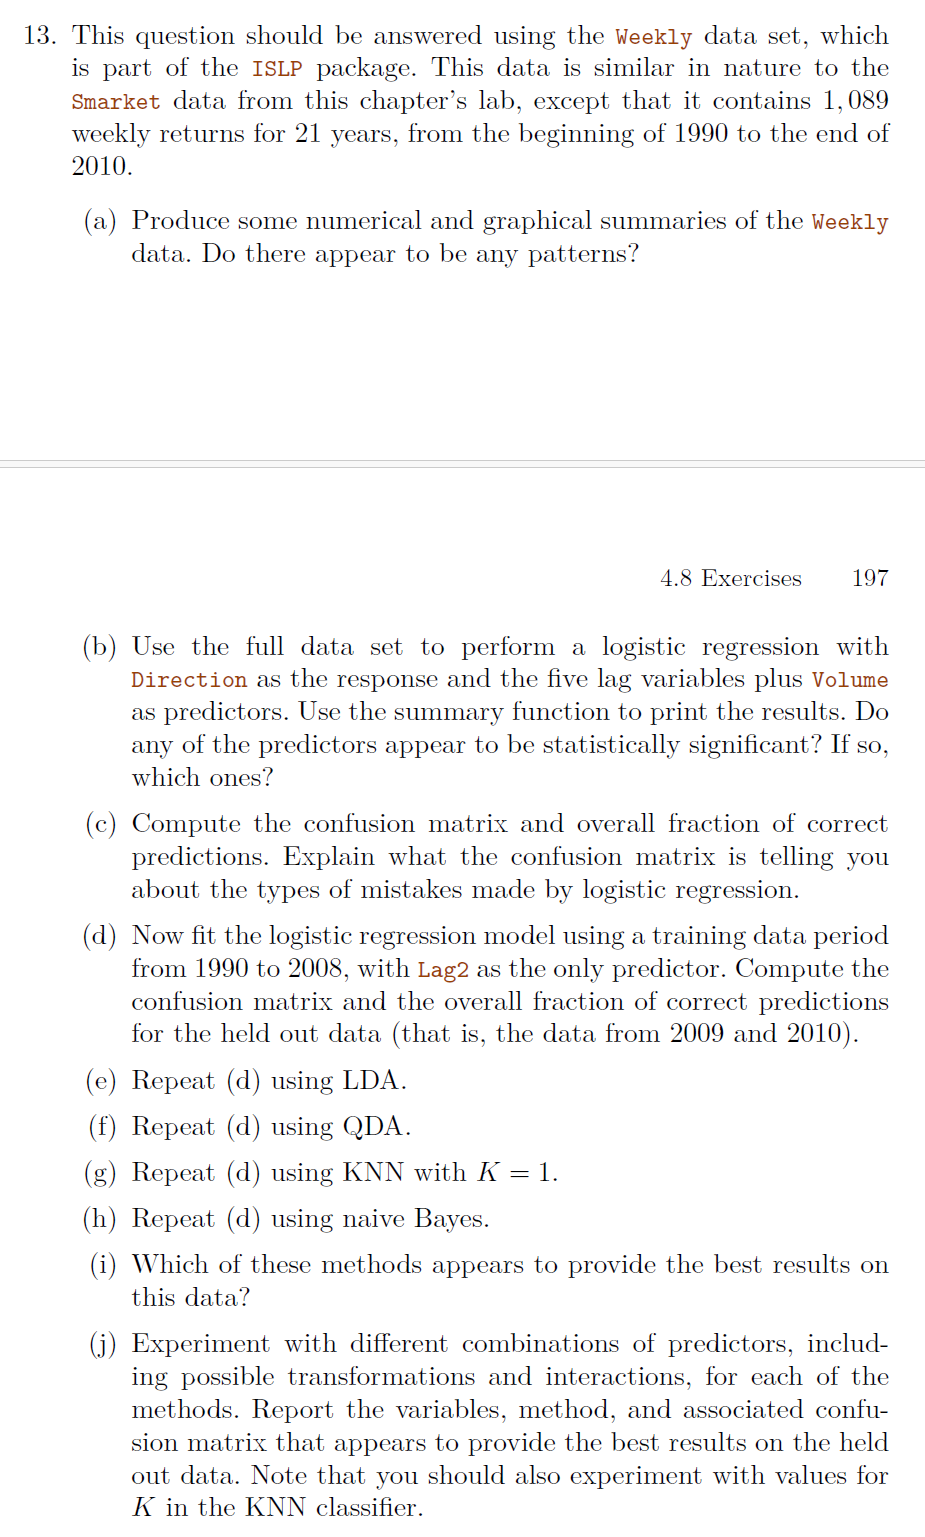

## a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [10]:
#Load the data
df = load_data('Weekly')
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [11]:
df.shape

(1089, 9)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1089 non-null   int64   
 1   Lag1       1089 non-null   float64 
 2   Lag2       1089 non-null   float64 
 3   Lag3       1089 non-null   float64 
 4   Lag4       1089 non-null   float64 
 5   Lag5       1089 non-null   float64 
 6   Volume     1089 non-null   float64 
 7   Today      1089 non-null   float64 
 8   Direction  1089 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 69.4 KB


## See core statistical summaries of the data for numerical columns

In [14]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


### Compute additional summary statistics for the dataset.
This gives us the option to see some metrics like number of outliers and spread related numbers.

In [16]:
def round_values(value, dp=3):
    if type(value) in [str, int]:
        return value
    return round(value, dp)

def get_outliers_iqr(data:list):
    """Detects outliers in a list of numbers using the IQR method."""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = []
    for num in data:
        if num < lower_bound or num > upper_bound:
            outliers.append(num)
    return outliers

def compute_summary_numbers(df):
    summary_metrics = []
    total_recs = df.shape[0]
    for column in df.columns:
        values = df[column].values.tolist()  # Corrected column access
        n_unique = len(set(values))
        number_of_nulls = df[column].isna().sum()  # Calculate nulls directly
        number_of_valid = total_recs - number_of_nulls
        data_type = str(df[column].dtype)
        mean = np.mean(values)
        std = np.std(values)
        fisher_kurtosis = stats.kurtosis(values, fisher=True)
        pearson_kurtosis = stats.kurtosis(values, fisher=False)
        skewness = stats.skew(values)
        min_value = min(values)
        max_value = max(values)
        percentile_25 = np.percentile(values, 25)
        percentile_50 = np.percentile(values, 50)
        percentile_75 = np.percentile(values, 75)
        iqr = percentile_75 - percentile_25
        lower_bound = percentile_25 - 1.5 * iqr
        upper_bound = percentile_75 + 1.5 * iqr

        outliers = [value for value in values if value > upper_bound or value < lower_bound]
        if(data_type == 'object'):
            data_type = 'str'
        outliers_percentage = 100* len(outliers)/total_recs
        completeness = round(100* number_of_nulls / total_recs, 3)  # Calculate completeness
        raw_values = [column, data_type, n_unique, mean, std, fisher_kurtosis, pearson_kurtosis, skewness,
                      min_value, percentile_25, percentile_50, percentile_75, max_value, len(outliers), outliers_percentage]
        rounded_values = [round_values(value) for value in raw_values]
        summary_metrics.append(rounded_values)
    return pd.DataFrame(summary_metrics, columns=['ColumnName', 'DataType', 'NUnique', 'Mean', 'Std', 'FisherKurtosis', 'PeasonKurtosis',
                                       'Skewness', 'Min', '25thPercentile', '50thPercentile', '75thPercentile', 'Max', 'NOutliers', 'OutliersPercent'])

# Create a DataFrame from the collected summary statistics
summary_stats = compute_summary_numbers(df.drop(['Direction'], axis = 1))
summary_stats

,ColumnName,DataType,NUnique,Mean,Std,FisherKurtosis,PeasonKurtosis,Skewness,Min,25thPercentile,50thPercentile,75thPercentile,Max,NOutliers,OutliersPercent
0,Year,int64,21,2000.049,6.030,-1.204,1.796,-0.002,1990.000,1995.000,2000.000,2005.000,2010.000,0,0.000
1,Lag1,float64,1004,0.151,2.356,5.685,8.685,-0.481,-18.195,-1.154,0.241,1.405,12.026,37,3.398
2,Lag2,float64,1005,0.151,2.356,5.682,8.682,-0.482,-18.195,-1.154,0.241,1.409,12.026,37,3.398
3,Lag3,float64,1005,0.147,2.359,5.639,8.639,-0.479,-18.195,-1.158,0.241,1.409,12.026,36,3.306
4,Lag4,float64,1005,0.146,2.359,5.641,8.641,-0.478,-18.195,-1.158,0.238,1.409,12.026,36,3.306
5,Lag5,float64,1005,0.140,2.360,5.625,8.625,-0.475,-18.195,-1.166,0.234,1.405,12.026,36,3.306
6,Volume,float64,1089,1.575,1.686,2.072,5.072,1.618,0.087,0.332,1.003,2.054,9.328,89,8.173
7,Today,float64,1003,0.150,2.356,5.685,8.685,-0.481,-18.195,-1.154,0.241,1.405,12.026,37,3.398


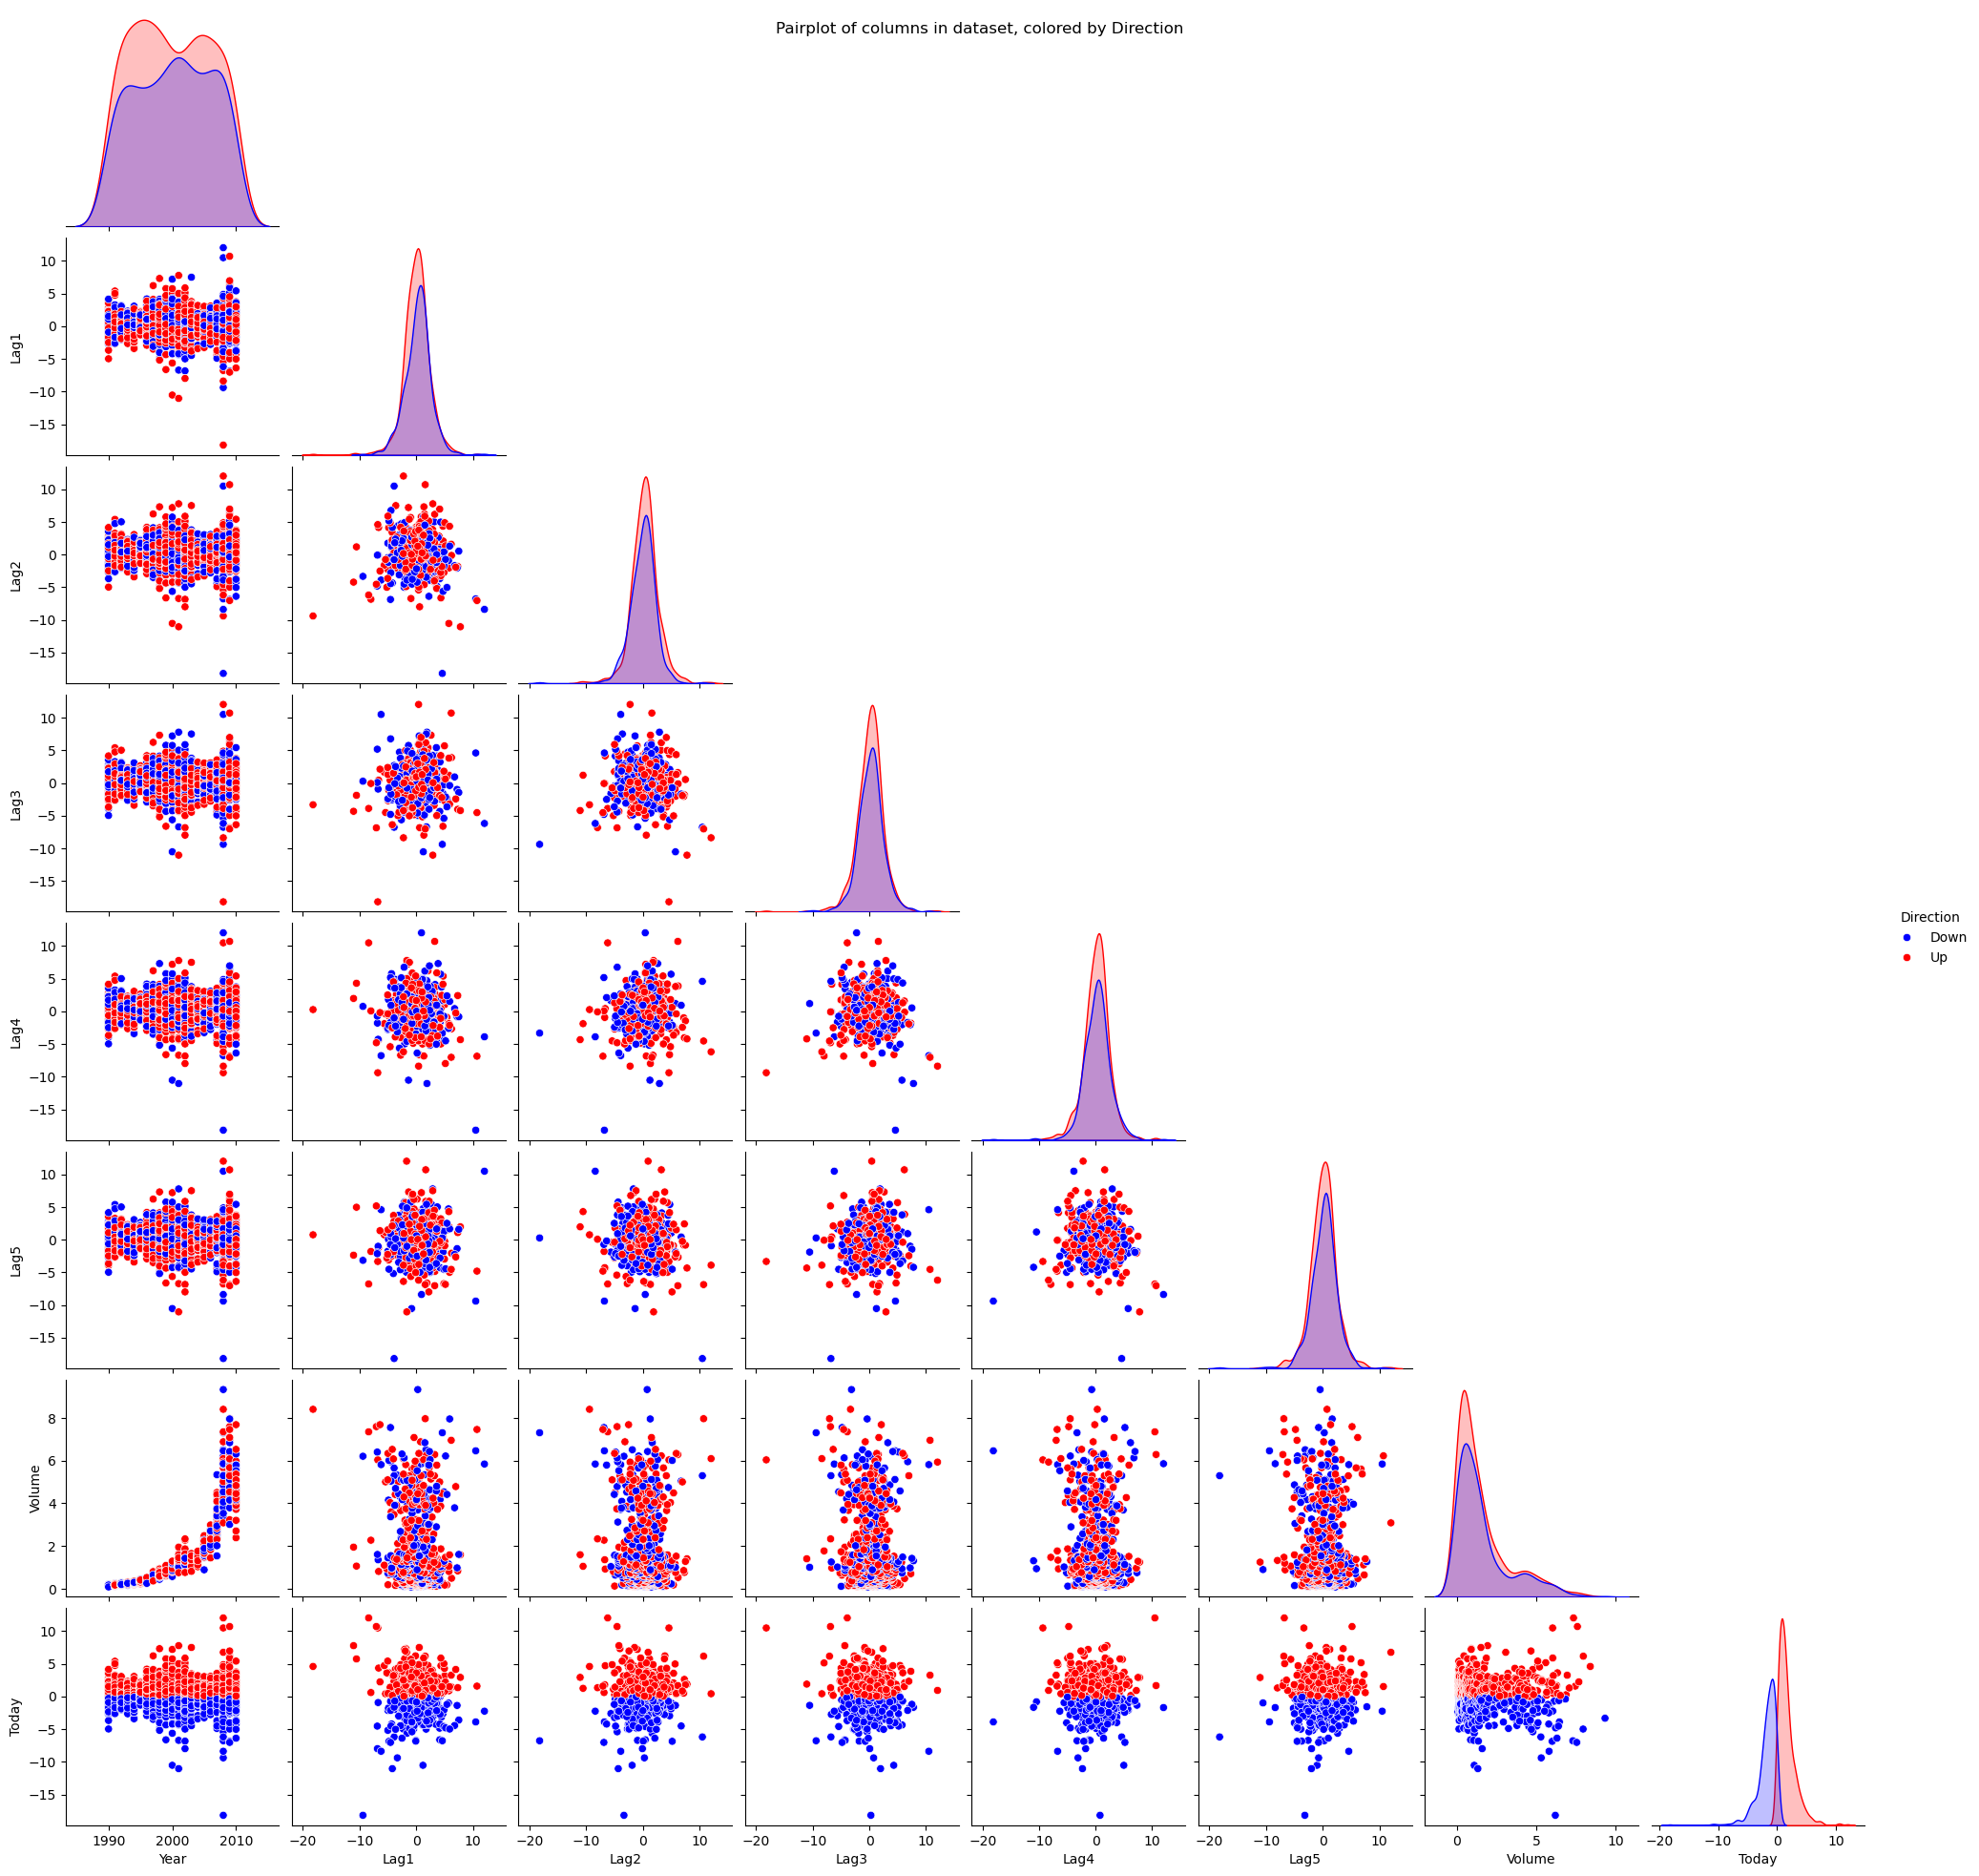

In [18]:
colors = [
    "blue",
    "red",
    "green",
    "gray",
    "orange",
    "purple",
    "brown",
    "pink",
    "cyan",
    "magenta"
]

g = sns.pairplot(df, corner=True, diag_kind='kde', hue='Direction', palette=colors[:df.Direction.nunique()])
# Set the title of the plot
g.fig.suptitle("Pairplot of columns in dataset, colored by Direction")
plt.show()

C:\Users\snde\AppData\Local\Temp\ipykernel_15380\2633844273.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['Year', 'Direction']).size().unstack()


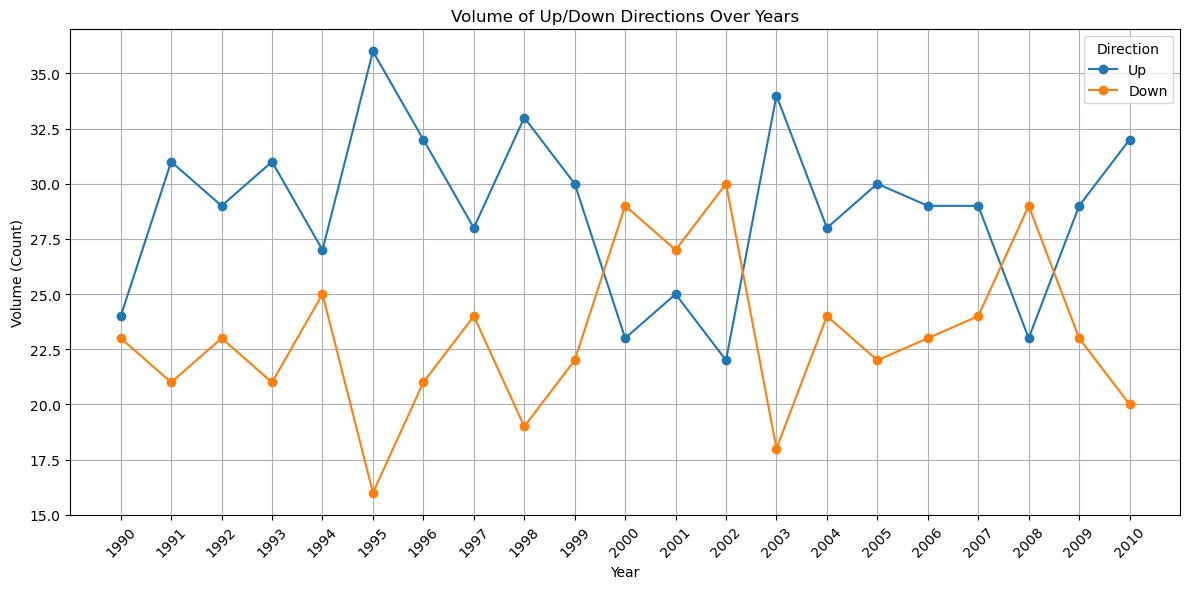

In [19]:
counts = df.groupby(['Year', 'Direction']).size().unstack()

# Plot the counts for 'Up' and 'Down' on the same axes
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(counts.index, counts['Up'], label='Up', marker='o')  # Plot 'Up'
plt.plot(counts.index, counts['Down'], label='Down', marker='o')  # Plot 'Down'

# Customize the plot
plt.title('Volume of Up/Down Directions Over Years')
plt.xlabel('Year')
plt.ylabel('Volume (Count)')
plt.xticks(counts.index, rotation=45)  # Set x-ticks to years and rotate
plt.legend(title='Direction')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df.Direction.value_counts()

Direction
Up      605
Down    484
Name: count, dtype: int64

### Observations from summary statistics and pair plots of the dataset.
- With the exception of Volume and Year, all the columns in the dataset have a high kurtosis meaning the distribution have sharp peaks with hevier tails.
- The dataset generally has outliers, all columns except the Year have outliers.
- With the exception of Year,the other columns tend to have the same range.
- The dataset is not balanced in that there are more `up Direction instances than Down`.

## Question 13 b)
b) Use the full data set to perform a logistic regression with
Direction as the response and the five lag variables plus Volume
as predictors. Use the summary function to print the results. Do
any of the predictors appear to be statistically significant? If so,
which ones?

In [23]:
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [24]:
## Fit Logistic Regression model using the 5 lag variables and the volume as the predictors

In [25]:
model_columns = [f"Lag{i}" for i in range(1, 6)] + ['Volume']
design = ModelSpec(model_columns)
X = design.fit_transform(df)
y = df.Direction == 'Up'
glm_lr = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm_lr.fit()
summarize(results)


,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


### From the logistic regression model, 
- Lag2 is the only statistically significant predictor at a 5% significance level (p = 0.030). The other lag variables and Volume do not appear to be statistically significant.

In [27]:
#Function to store all metrics for later comparison
def get_result_summary(y_true, y_pred, model_description:str):
    return [model_description,
            round(accuracy_score(y_true, y_pred), 4),
            round(precision_score(y_true, y_pred), 4),
            round(recall_score(y_true, y_pred), 4),
            round(f1_score(y_true, y_pred), 4),
            len(y_true)
           ]
comparison_table_data = []

## Question 13 c)
Compute the confusion matrix and overall fraction of correct
predictions. Explain what the confusion matrix is telling you
about the types of mistakes made by logistic regression.

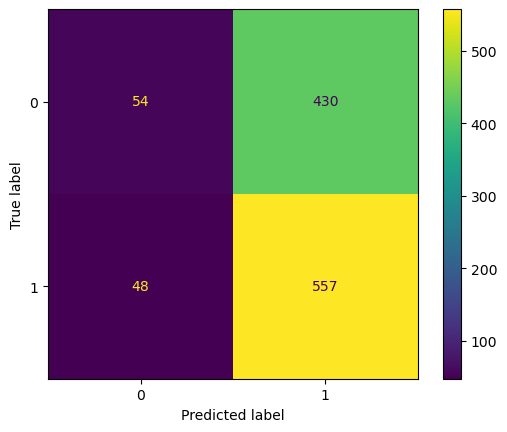

In [29]:
y_pred_logistic_probs = results.predict()

y_pred_logistic = np.array(['Down']*df.shape[0])
y_pred_logistic[y_pred_logistic_probs>0.5] = "Up"
cm = confusion_matrix(df.Direction.values, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

In [30]:
y_true, y_pred = [1 if d == 'Up' else 0 for d in df.Direction], [1 if d == 'Up' else 0 for d in y_pred_logistic]
print(f"Precision Score {precision_score(y_true, y_pred)}")
print(f"Recall Score {recall_score(y_true, y_pred)}")
print(f"F1 Score {f1_score(y_true, y_pred)}")
print(f"Accuracy Score {accuracy_score(y_true, y_pred)}")

Precision Score 0.5643363728470111
Recall Score 0.9206611570247933
F1 Score 0.699748743718593
Accuracy Score 0.5610651974288338


In [31]:
comparison_table_data.append(get_result_summary(y_true, y_pred, 'LR(Lag 1-5 & Volume)'))
comparison_table_data

[['LR(Lag 1-5 & Volume)', 0.5611, 0.5643, 0.9207, 0.6997, 1089]]


# Model Performance Summary

##**Confusion Matrix Interpretati*rix}
\]
- **True Negatives (TN):** 54 → The model correctly predicted "Down" (negative class) 54 times.  
- **False Positives (FP):** 430 → The model incorrectly predicted "Up" (positive class) when it was actually "Down."  
- **False Negatives (FN):** 48 → The model incorrectly predicted "Down" when it was actually "Up."  
- **True Positives (TP):** 557 → The model correctly predicted "Up" (positive class) 557 tis.  

### **Perfoance Metrics**
| Metric      | Value  |
|------------|--------|
| **Precision** | 0.5643 (56.43%) |
| **Recall** | 0.9207 (92.07%) |
| **F1 Score** | 0.6997 |
| **Accuracy** | 0.5611 (56.11%) |

- **Precision**: Among all instances predicted as "Up," only **56.43%** were correct. A low precision score suggests a high false positive rate.  
- **Recall**: The model correctly identified **92.07%** of actual "Up" cases. This high recall indicates the model captures most positive instances but misclassifies many "Down" cases.  
- **F1 Score**: A balance between precision and recall, showing a moderate trade-off.  
- **Accuracy**: The model correctly classified **56.11%** of all instances, which is only slightly better than random guessing.  

### **Conclusion**
The model has a **high recall but low precision and accuracy**. This suggests a bias toward predicting "Up" while often misclassifying "Down." 

#### **Potential Improvements**
- **Balancing the dataset** (if class imbalance exists).
- **Tuning decision thresholds** to optimize precision-recall trade-offs.
- **Trying alternative models** like Random Forest or Gradient Boosting for better classification performance.



## Model Performance Summary

### Confusion Matrix Interpretation

- **True Negatives (TN):** 54 → The model correctly predicted "Down" (negative class) 54 times.  
- **False Positives (FP):** 430 → The model incorrectly predicted "Up" (positive class) when it was actually "Down."  
- **False Negatives (FN):** 48 → The model incorrectly predicted "Down" when it was actually "Up."  
- **True Positives (TP):** 557 → The model correctly predicted "Up" (positive class) 557 times.  

### Performance Metrics
| Metric      | Value  |
|------------|--------|
| **Precision** | 0.5643 (56.43%) |
| **Recall** | 0.9207 (92.07%) |
| **F1 Score** | 0.6997 (69,97%)|
| **Accuracy** | 0.5611 (56.11%) |

- **Precision**: Among all instances predicted as "Up," only **56.43%** were correct. A low precision score suggests a high false positive rate.  
- **Recall**: The model correctly identified **92.07%** of actual "Up" cases. This high recall indicates the model captures most positive instances but misclassifies many "Down" cases.  
- **F1 Score**: A balance between precision and recall, showing a moderate trade-off.  
- **Accuracy**: The model correctly classified **56.11%** of all instances, which is only slightly better than random guessing.  

### **Conclusion**
The model has a **high recall but low precision and accuracy**. This suggests a bias toward predicting "Up" while often misclassifying "Down." 

#### **Potential Improvements**
- **Balancing the dataset** (if class imbalance exists).
- **Tuning decision thresholds** to optimize precision-recall trade-offs.
- **Trying alternative models** like Random Forest or Gradient Boosting for better classification performance.


### Question 13 d)
Now fit the logistic regression model using a training data period
from 1990 to 2008, with Lag2 as the only predictor. Compute the
confusion matrix and the overall fraction of correct predictions
for the held out data (that is, the data from 2009 and 2010).

In [35]:
X_train, L_train = df[df.Year <2008][['Lag2']], np.ravel(df[df.Year <2008]['Direction'])
X_test, L_test = df[df.Year >2008][['Lag2']], np.ravel(df[df.Year >2008]['Direction'])

y_test_str =  np.ravel(L_train)
model_columns = ['Lag2']
design = ModelSpec(model_columns)
X_train = design.fit_transform(X_train)
y_train = np.ravel([1 if i == 'Up' else 0 for i in L_train])

X_test = design.transform(X_test)
y_test = np.ravel([1 if i == 'Up' else 0 for i in L_test])
glm_lr = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm_lr.fit()
summarize(results)


,coef,std err,z,P>|z|
intercept,0.2266,0.066,3.422,0.001
Lag2,0.0472,0.032,1.460,0.144


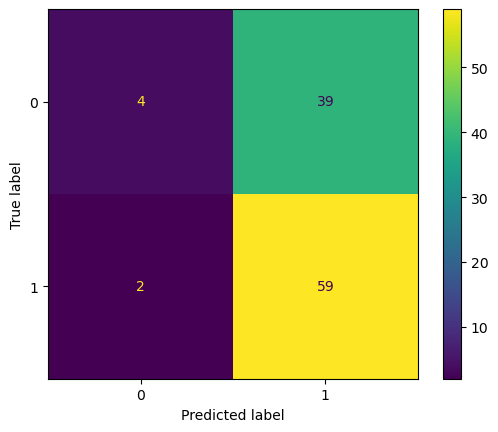

In [36]:
y_pred_logistic_probs = results.predict(X_test)

y_pred_logistic = np.array(['Down']*L_test.shape[0])
y_pred_logistic[y_pred_logistic_probs>0.5] = "Up"
cm = confusion_matrix(L_test, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()
# Print predictions


In [37]:
print(cm)

[[ 4 39]
 [ 2 59]]


In [38]:
y_pred_logistic_probs = results.predict(X_test)
y_pred = (y_pred_logistic_probs >= 0.5).astype(int)
comparison_table_data.append(get_result_summary(y_test, y_pred, 'LR(Lag2 Only, Test)'))
comparison_table_data

[['LR(Lag 1-5 & Volume)', 0.5611, 0.5643, 0.9207, 0.6997, 1089],
 ['LR(Lag2 Only, Test)', 0.6058, 0.602, 0.9672, 0.7421, 104]]

## Question 13 e)
Now fit the LDA model using a training data period
from 1990 to 2008, with Lag2 as the only predictor. Compute the
confusion matrix and the overall fraction of correct predictions
for the held out data (that is, the data from 2009 and 2010).

In [40]:
## Perform LDA


In [41]:
lda = LDA(store_covariance=True)


In [42]:
# X_train, X_test = [M.drop(columns=['intercept'])
#                    for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [43]:
lda.priors_

array([0.44158628, 0.55841372])

The LDA output indicates that $\hat\pi_{Down}=0.442$ and
$\hat\pi_{Up}=0.558$.


In [45]:
y_pred_str = lda.predict(X_test)

In [46]:
y_pred

985     1
986     1
987     1
988     1
989     1
       ..
1084    1
1085    1
1086    1
1087    1
1088    1
Length: 104, dtype: int32

In [47]:
confusion_table(y_pred_str, L_test)


Truth,Down,Up
Predicted,,
Down,3,2
Up,40,59


In [48]:
y_true, y_pred_test = [1  if i == 'Up' else 0 for i in L_test], [1  if i == 'Up' else 0 for i in y_pred_str]

comparison_table_data.append(get_result_summary(y_true, y_pred_test, 'LDA(Lag2 Only Test- Set)'))
comparison_table_data

[['LR(Lag 1-5 & Volume)', 0.5611, 0.5643, 0.9207, 0.6997, 1089],
 ['LR(Lag2 Only, Test)', 0.6058, 0.602, 0.9672, 0.7421, 104],
 ['LDA(Lag2 Only Test- Set)', 0.5962, 0.596, 0.9672, 0.7375, 104]]

### Question 13 f)
Now fit the QDA model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

### QDA

In [50]:
#Fit qda model and inspect the covariance matrix.
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)
qda.covariance_[0]


C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


array([[0.        , 0.        ],
       [0.        , 3.54818021]])

### See the confusion table of predictions.

In [52]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)


C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


Truth,Down,Up
Predicted,,
Down,43,61
Up,0,0


In [53]:
y_true, y_pred_test = [1  if i == 'Up' else 0 for i in L_test], [1  if i == 'Up' else 0 for i in qda_pred]

comparison_table_data.append(get_result_summary(y_true, y_pred_test, 'QDA(Lag2 Only Test- Set)'))
comparison_table_data

C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[['LR(Lag 1-5 & Volume)', 0.5611, 0.5643, 0.9207, 0.6997, 1089],
 ['LR(Lag2 Only, Test)', 0.6058, 0.602, 0.9672, 0.7421, 104],
 ['LDA(Lag2 Only Test- Set)', 0.5962, 0.596, 0.9672, 0.7375, 104],
 ['QDA(Lag2 Only Test- Set)', 0.4135, 0.0, 0.0, 0.0, 104]]

### Question 13 g)
Now fit the KNN (k=1) model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

### KNN(k=1)

In [55]:
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(X_train, L_train)

KNeighborsClassifier(n_neighbors=1)

### Get predictions and a confusion table

In [57]:
y_pred_knn1 = knn1.predict(X_test)

confusion_table(y_pred_knn1, L_test)

Truth,Down,Up
Predicted,,
Down,21,32
Up,22,29


In [58]:
y_true, y_pred_test = [1  if i == 'Up' else 0 for i in L_test], [1  if i == 'Up' else 0 for i in y_pred_knn1]

comparison_table_data.append(get_result_summary(y_true, y_pred_test, 'KNN 1 Neighbor(Lag2 Only Test- Set)'))
comparison_table_data

[['LR(Lag 1-5 & Volume)', 0.5611, 0.5643, 0.9207, 0.6997, 1089],
 ['LR(Lag2 Only, Test)', 0.6058, 0.602, 0.9672, 0.7421, 104],
 ['LDA(Lag2 Only Test- Set)', 0.5962, 0.596, 0.9672, 0.7375, 104],
 ['QDA(Lag2 Only Test- Set)', 0.4135, 0.0, 0.0, 0.0, 104],
 ['KNN 1 Neighbor(Lag2 Only Test- Set)', 0.4808, 0.5686, 0.4754, 0.5179, 104]]

### Question 13 e)
Now fit the Naive Bayes model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

### Naive Bayes

In [60]:
model_nb=BernoulliNB()
model_nb=model_nb.fit(X_train,L_train) 
preds_nb=model_nb.predict(X_test) 
# print(classification_report(y,mypred))

In [61]:
print(classification_report(L_test, preds_nb))

              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        43
          Up       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104



C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
confusion_table(preds_nb, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [63]:
y_true, y_pred_test = [1  if i == 'Up' else 0 for i in L_test], [1  if i == 'Up' else 0 for i in preds_nb]

comparison_table_data.append(get_result_summary(y_true, y_pred_test, 'Naive Bayes(Lag2 Only Test- Set)'))
comparison_table_data

[['LR(Lag 1-5 & Volume)', 0.5611, 0.5643, 0.9207, 0.6997, 1089],
 ['LR(Lag2 Only, Test)', 0.6058, 0.602, 0.9672, 0.7421, 104],
 ['LDA(Lag2 Only Test- Set)', 0.5962, 0.596, 0.9672, 0.7375, 104],
 ['QDA(Lag2 Only Test- Set)', 0.4135, 0.0, 0.0, 0.0, 104],
 ['KNN 1 Neighbor(Lag2 Only Test- Set)', 0.4808, 0.5686, 0.4754, 0.5179, 104],
 ['Naive Bayes(Lag2 Only Test- Set)', 0.5865, 0.5865, 1.0, 0.7394, 104]]

###  Question 13 i)
Which of the models above is the best.

### Comparison of Models

In [65]:
models_results = pd.DataFrame(comparison_table_data, columns ='ModelDescription Accuracy Precision Recall F1 NumberOfSamples'.split())
models_results.drop_duplicates(subset = ['ModelDescription'], keep = 'last', inplace=True)
models_results

,ModelDescription,Accuracy,Precision,Recall,F1,NumberOfSamples
0,LR(Lag 1-5 & Volume),0.5611,0.5643,0.9207,0.6997,1089
1,"LR(Lag2 Only, Test)",0.6058,0.6020,0.9672,0.7421,104
2,LDA(Lag2 Only Test- Set),0.5962,0.5960,0.9672,0.7375,104
3,QDA(Lag2 Only Test- Set),0.4135,0.0000,0.0000,0.0000,104
4,KNN 1 Neighbor(Lag2 Only Test- Set),0.4808,0.5686,0.4754,0.5179,104
5,Naive Bayes(Lag2 Only Test- Set),0.5865,0.5865,1.0000,0.7394,104


## Best Model:

**Logistic Regression (Lag2 Only, Test)** is the best choice because it has:
- **Highest Accuracy (0.6058)**
- **Best F1-score (0.7421), balancing precision and recall**
- **High Recall (0.9672), meaning it correctly identifies most "Up" cases**


## Alternative Consideration:

- **Naive Bayes** has perfect recall (**1.0000**) but slightly lower F1-score (**0.7394**).  
- If your goal is to **minimize false negatives** (i.e., ensure you predict "Up" as much as possible), **Naive Bayes** might be better.  
- If you need a **more balanced model**, Logistic Regression (Lag2 Only, Test) is the best.


### Finding Alternative combination of features that can improve models

For this purpose, I will start with Lag2 and implement forward feature selection.

I will use `Precision` as my target score.

In [68]:
def get_non_empty_subsets(input_list):
  """Generates all non-empty subsets of a given list."""
  subsets = []
  for i in range(1, 1 << len(input_list)):  # Iterate through all possible subsets (excluding empty set)
    subset = []
    for j in range(len(input_list)):
      if (i >> j) & 1:  # Check if the j-th bit is set in i
        subset.append(input_list[j])
    subsets.append(subset)
  return subsets

In [69]:
# Split data into train and test sets
possible_predictors = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
predictor_sets = get_non_empty_subsets(possible_predictors)
X_train, y_train= df[df.Year <2008][possible_predictors], (df[df.Year <2008]['Direction'] == 'Up').astype(int)
X_test, y_test = df[df.Year >2008][possible_predictors], (df[df.Year >2008]['Direction'] == 'Up').astype(int)
# Forward Feature Selection
best_precision = 0
best_model = None
feature_scores = []

# Start with an empty set and add features one by one
selected_features = []
for predictor_set in predictor_sets:
    X_train_subset = X_train[predictor_set]
    X_test_subset = X_test[predictor_set]
    
    # Train Logistic Regression model
    model = sm.Logit(y_train, sm.add_constant(X_train_subset)).fit(disp=0)
    y_pred = (model.predict(sm.add_constant(X_test_subset)) > 0.5).astype(int)
    
    # Calculate precision
    current_precision = precision_score(y_test, y_pred)
    if current_precision > best_precision:
        best_precision = current_precision
        cm = confusion_matrix(y_test, y_pred)
        feature_scores.append([','.join(predictor_set), current_precision, cm, model])

# Select the best feature that improves precision
feature_scores.sort(key=lambda x: x[1], reverse=True)
best_features, best_precision, best_confusion_matrix, best_model = feature_scores[0]



# Print results
print(f"Best Feature Set: {best_features}")
print(f"Best Precision Score: {best_precision:.4f}")

print(f"Best Confusion Matrix: \n {best_confusion_matrix}")

# Summary of the best model
print(best_model.summary())

Best Feature Set: Lag2,Lag3,Lag4,Volume
Best Precision Score: 0.6395
Best Confusion Matrix: 
 [[12 31]
 [ 6 55]]
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                  933
Model:                          Logit   Df Residuals:                      928
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                0.002474
Time:                        02:01:53   Log-Likelihood:                -638.74
converged:                       True   LL-Null:                       -640.32
Covariance Type:            nonrobust   LLR p-value:                    0.5301
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2591      0.103      2.516      0.012       0.057       0.461
Lag2           0.0

In [70]:
improvement = pd.DataFrame(feature_scores, columns = 'best_features, best_precision, best_confusion_matrix, best_model'.split(', '))
improvement

,best_features,best_precision,best_confusion_matrix,best_model
0,"Lag2,Lag3,Lag4,Volume",0.639535,"[[12, 31], [6, 55]]",<statsmodels.discrete.discrete_model.BinaryRes...
1,"Lag1,Lag2,Lag4,Volume",0.632911,"[[14, 29], [11, 50]]",<statsmodels.discrete.discrete_model.BinaryRes...
2,"Lag2,Lag3,Lag4",0.621053,"[[7, 36], [2, 59]]",<statsmodels.discrete.discrete_model.BinaryRes...
3,"Lag2,Lag4",0.604167,"[[5, 38], [3, 58]]",<statsmodels.discrete.discrete_model.BinaryRes...
4,Lag2,0.602041,"[[4, 39], [2, 59]]",<statsmodels.discrete.discrete_model.BinaryRes...
5,Lag1,0.597938,"[[4, 39], [3, 58]]",<statsmodels.discrete.discrete_model.BinaryRes...


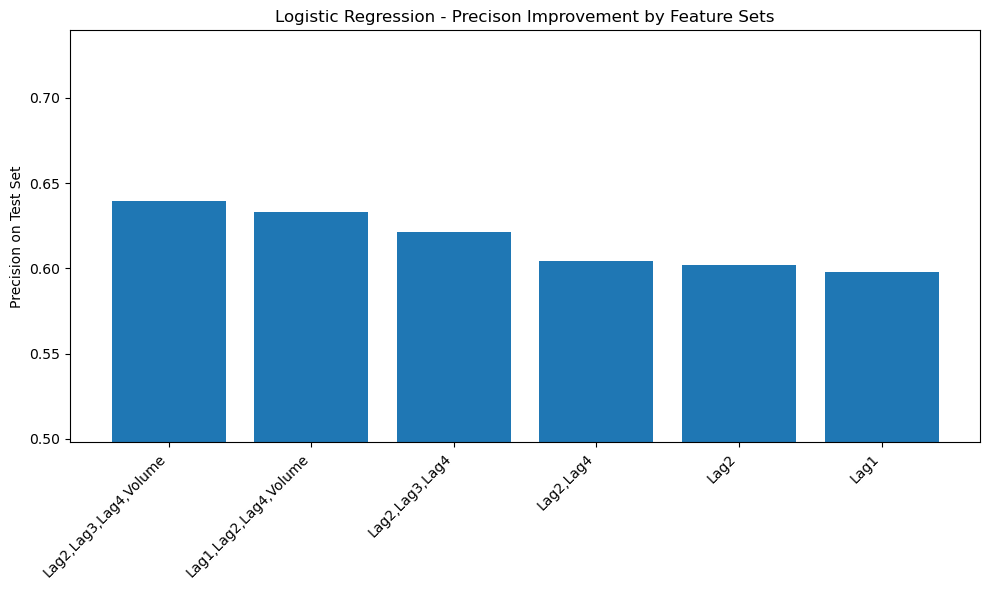

In [71]:
def plot_precision_by_features(df, model_type:str):
    """Plots a DataFrame with 'best_features' (str) and 'best_precision' (float) columns."""

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    min_precision, max_prescision = df['best_precision'].min(), df['best_precision'].max()
    # Option 1: Bar Chart (for discrete labels)
    plt.bar(df['best_features'], df['best_precision'])

    # Option 2: Line Chart (if labels represent a continuous or ordered sequence)
    # plt.plot(df['Label'], df['Value'], marker='o')

    plt.title(f'{model_type} - Precison Improvement by Feature Sets')
    # plt.xlabel('Features')
    plt.ylabel('Precision on Test Set')
    plt.ylim([max(min_precision-0.1, 0), min(max_prescision+ 0.1, 1)])

    # Rotate x-axis labels for better readability (if needed)
    plt.xticks(rotation=45, ha='right')  # Rotate and align right

    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()

# Call the plotting function
plot_precision_by_features(improvement, 'Logistic Regression')

### Best Logistic Regression Model
As shown below, the best logistic Regression model uses the variables `Lag2, Lag3, Lag4 and Volume`.

This model has a precision score of 63.95%.

## K-Nearest Neighbors (KNN) Feature Selection

We will evaluate **KNN models** using different **feature sets** from `prediction_sets` and **neighbors (k) from 1 to 12**.  
The goal is to find the **best feature set for each k** based on **precision score**.

In [74]:
best_knn_results = {}
feature_scores_knn = []
# Loop through k values from 1 to 12
for k in range(1, 13):
    best_precision = 0
    best_features = None
    best_confusion_matrix = None
    
    # Loop through all predefined feature sets
    for predictor_set in predictor_sets:
        X_train_subset = X_train[predictor_set]
        X_test_subset = X_test[predictor_set]
        
        # Train KNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_subset, y_train)
        y_pred = knn.predict(X_test_subset)
        
        # Update best feature set if precision improves
        current_precision = precision_score(y_test, y_pred)
        if current_precision > best_precision:
            best_precision = current_precision
            best_confusion_matrix = confusion_matrix(y_test, y_pred)
            feature_scores_knn.append([','.join(predictor_set)+ f'|{k}', current_precision, cm])
    
    # Store results for the best feature set at k
    best_knn_results[k] = (','.join(predictor_set), best_precision, best_confusion_matrix)

# Display results
print("Best Feature Set for Each k:")
for k, (features, precision, cm) in best_knn_results.items():
    print(f"k={k}: Best Features = {features}, Precision = {precision:.4f}")


Best Feature Set for Each k:
k=1: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6774
k=2: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.7692
k=3: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6774
k=4: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.7419
k=5: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6833
k=6: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.7059
k=7: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6618
k=8: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.7500
k=9: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6557
k=10: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.7500
k=11: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6528
k=12: Best Features = Lag1,Lag2,Lag3,Lag4,Lag5,Volume, Precision = 0.6739


In [75]:
knn_best_models= pd.DataFrame([[key, value[0], value[1], value[2]] for key, value in best_knn_results.items()], columns = 'k best_features best_precision confusion_matrix'.split())
knn_best_models

,k,best_features,best_precision,confusion_matrix
0,1,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.677419,"[[33, 10], [40, 21]]"
1,2,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.769231,"[[34, 9], [31, 30]]"
2,3,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.677419,"[[23, 20], [19, 42]]"
3,4,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.741935,"[[35, 8], [38, 23]]"
4,5,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.683333,"[[24, 19], [20, 41]]"
5,6,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.705882,"[[33, 10], [37, 24]]"
6,7,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.661765,"[[20, 23], [16, 45]]"
7,8,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.750000,"[[42, 1], [58, 3]]"
8,9,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.655738,"[[22, 21], [21, 40]]"
9,10,"Lag1,Lag2,Lag3,Lag4,Lag5,Volume",0.750000,"[[42, 1], [58, 3]]"


## Best Models for KNN
As we have seen in the output above, the best outcome for KNN is achieved when all the 5 features are used and the pest precision occurs for 2 neighbors.